In [1]:

%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pickle
import uproot as ur
import awkward as ak
import matplotlib.pyplot as plt

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "5"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#RUN BEFORE#

In [4]:
#RUN AFTER#

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras as keras
K = keras.backend

from util.Models import *
from util.Generators import *
from util.Plotting import *


In [5]:

data_path = '/fast_scratch_1/atlas_images/v01-45/'

cell_geo_path = data_path + 'cell_geo.root'

out_path = '/fast_scratch_1/jlerner/data/'


In [6]:

with ur.open(data_path + 'pi0/user.angerami.24559740.OutputStream._000232.root') as file:
    pi0_data = file['EventTree'].arrays(library='ak')
    
with ur.open(data_path + 'pipm/user.angerami.24559744.OutputStream._000232.root') as file:
    pipm_data = file['EventTree'].arrays(library='ak')
    
orig_pred = np.concatenate((ak.flatten(pipm_data['cluster_E']), 
                            ak.flatten(pi0_data['cluster_E']))).to_numpy()

orig_target = np.concatenate((ak.flatten(pipm_data['cluster_ENG_CALIB_TOT']), 
                              ak.flatten(pi0_data['cluster_ENG_CALIB_TOT']))).to_numpy()


In [7]:
norm = 'log' # 'log', 'std', or 'max'

if norm == 'log':
    scaler = None
elif norm == 'std':
    scaler = StandardScaler()
elif norm == 'max':
    scaler = MinMaxScaler()

sample = orig_target.reshape(-1, 1)

if scaler is not None:
    scaler.fit(sample)

normalizer = (norm, scaler)

In [8]:
preprocess = True
train = True

In [9]:
if train:
    K.clear_session()
    model = GarNetModel(alpha=0.50, normalizer=normalizer[0])


2023-06-08 14:43:31.947155: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-08 14:43:31.947396: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4637 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:89:00.0, compute capability: 7.5


In [10]:

train_val_split = 0.8
batch_size = 64

pi0_list = [[data_path + f'pi0/user.angerami.24559740.OutputStream._000{i:03d}.root', 1] 
            for i in list(range(11, 113)) + list(range(116, 232))]
pipm_list = [[data_path + f'pipm/user.angerami.24559744.OutputStream._000{i:03d}.root', 0] 
             for i in list(range(11, 113)) + list(range(116, 232))]

np.random.shuffle(pi0_list)
np.random.shuffle(pipm_list)

train_start = 0
train_end = train_start + int(train_val_split*len(pi0_list))
val_start = train_end
val_end = len(pi0_list)
train_file_list = (pi0_list[train_start:train_end], pipm_list[train_start:train_end])
val_file_list = (pi0_list[val_start:val_end], pipm_list[val_start:val_end])

test_file_list = ([[data_path + f'pi0/user.angerami.24559740.OutputStream._000{i:03d}.root', 1] for i in range(232, 264)],
                  [[data_path + f'pipm/user.angerami.24559744.OutputStream._000{i:03d}.root', 0] for i in range(232, 264)])


In [11]:

train_generator = garnetDataGenerator(train_file_list, 
                                      cell_geo_path, 
                                      batch_size,
                                      normalizer=normalizer,
                                      name='garnet_' + normalizer[0],
                                      labeled=True, 
                                      preprocess=preprocess, 
                                      output_dir=out_path + 'train/')

if preprocess: cell_geo_path = train_generator.geo_dict

validation_generator = garnetDataGenerator(val_file_list, 
                                           cell_geo_path,
                                           int(batch_size*(1 - train_val_split)/train_val_split),
                                           normalizer=normalizer,
                                           name='garnet_' + normalizer[0],
                                           labeled=True, 
                                           preprocess=preprocess, 
                                           output_dir=out_path + 'val/')

test_generator = garnetDataGenerator(test_file_list,
                                     cell_geo_path,
                                     batch_size=20000,
                                     normalizer=normalizer,
                                     name='garnet_' + normalizer[0],
                                     labeled=True,
                                     preprocess=preprocess,
                                     output_dir=out_path + 'test/')



Loading Geo Dictionary...
	Starting on cell_geo_sampling
	Starting on cell_geo_eta
	Starting on cell_geo_phi
Finished loading Geo Dictionary

Preprocessing and saving data to /fast_scratch_1/jlerner/data/train/

Preprocessing and saving data to /fast_scratch_1/jlerner/data/val/

Preprocessing and saving data to /fast_scratch_1/jlerner/data/test/


In [12]:
if train:
    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    
    history = model.fit(train_generator.generator(), 
                        validation_data=validation_generator.generator(),
                        steps_per_epoch=800,
                        validation_steps=200,
                        shuffle=True,
                        epochs=100,
                        callbacks=[callback],
                        verbose=2)
    model.save(out_path + 'models/GarNet_' + normalizer[0]) # note that the scaler will not be saved

    with open(out_path + 'models/GarNet_' + normalizer[0] + '/history.pickle', 'wb') as handle:
        pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

2023-06-08 15:09:54.998501: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
800/800 - 51s - loss: 1.9668 - accuracy: 0.7641 - val_loss: 1.3372 - val_accuracy: 0.7633
Epoch 2/100
800/800 - 34s - loss: 1.1060 - accuracy: 0.7843 - val_loss: 0.8885 - val_accuracy: 0.8040
Epoch 3/100
800/800 - 42s - loss: 0.8242 - accuracy: 0.8169 - val_loss: 0.6701 - val_accuracy: 0.8393
Epoch 4/100
800/800 - 42s - loss: 0.7208 - accuracy: 0.8243 - val_loss: 0.6489 - val_accuracy: 0.8477
Epoch 5/100
800/800 - 41s - loss: 0.6560 - accuracy: 0.8288 - val_loss: 0.5834 - val_accuracy: 0.8470
Epoch 6/100
800/800 - 41s - loss: 0.6165 - accuracy: 0.8381 - val_loss: 0.5422 - val_accuracy: 0.8597
Epoch 7/100
800/800 - 42s - loss: 0.6043 - accuracy: 0.8385 - val_loss: 0.5566 - val_accuracy: 0.8490
Epoch 8/100
800/800 - 41s - loss: 0.5712 - accuracy: 0.8438 - val_loss: 0.5593 - val_accuracy: 0.8487
Epoch 9/100
800/800 - 41s - loss: 0.5585 - accuracy: 0.8451 - val_loss: 0.5111 - val_accuracy: 0.8593
Epoch 10/100
800/800 - 41s - loss: 0.5508 - accuracy: 0.8454 - val_loss: 0.5141 - 

2023-06-08 16:02:36.590594: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /fast_scratch_1/jlerner/data/models/GarNet_log/assets


INFO:tensorflow:Assets written to: /fast_scratch_1/jlerner/data/models/GarNet_log/assets


In [13]:

K.clear_session()
model = tf.keras.models.load_model(out_path + 'models/GarNet_' + normalizer[0], custom_objects={"GarNetModel": GarNetModel}, compile=False)
with open(out_path + 'models/GarNet_' + normalizer[0] + '/history.pickle', "rb") as file:
    history = pickle.load(file)
x, y = next(test_generator.generator())


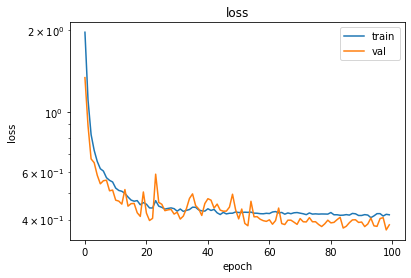

In [14]:
loss_curve = Plotter(training, history=history, metric='loss', scale='log')
loss_curve.show()

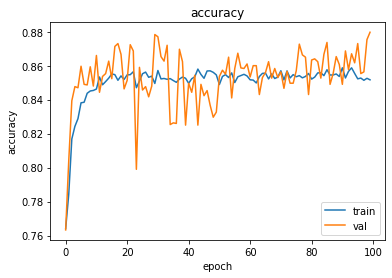

In [15]:
accuracy_curve = Plotter(training, history=history, metric='accuracy')
accuracy_curve.show()

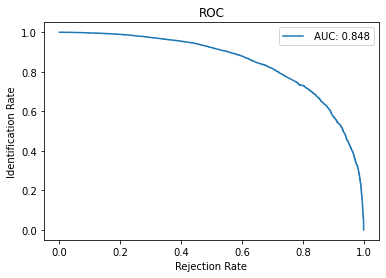

In [16]:
ROC = Plotter(roc, pred=model.predict(x)[:,0], target=y[:,0])
ROC.show()

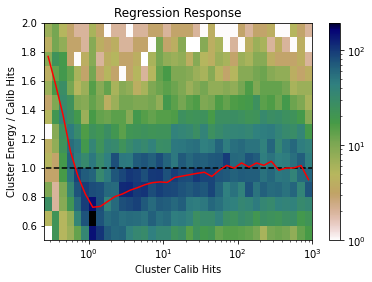

In [17]:
if normalizer[0] == 'std':
    scaler = normalizer[1]
    fit_pred = scaler.inverse_transform(np.reshape(model.predict(x)[:,-1], (-1, 1))).reshape(-1,)
    fit_target = scaler.inverse_transform(np.reshape(y[:,-1], (-1, 1))).reshape(-1,)
elif normalizer[0] == 'max':
    fit_pred = 2000*model.predict(x)[:,-1]
    fit_target = 2000*y[:,-1]
elif normalizer[0] == 'log':
    fit_pred = np.exp(model.predict(x)[:,-1])
    fit_target = np.exp(y[:,-1])
else:
    fit_pred = model.predict(x)[:, -1]
    fit_target = y[:, -1]

reg = Plotter(regResponse, 
              pred=fit_pred, 
              target=fit_target,
              stat=['median'])
reg.show()

/home/joshualerner/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


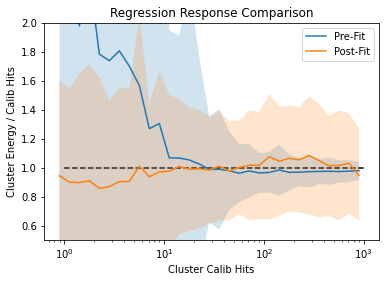

In [18]:
reg = Plotter(regResponseOverlay,
              preds=[orig_pred, fit_pred],
              targets=[orig_target, fit_target],
              labels=['Pre-Fit', 'Post-Fit'],
              stat=['mean', 'stdmean'])